In [1]:
##importing required libraries
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import numpy as np

from scipy.ndimage import rotate, shift
from scipy.signal import convolve2d

import random

import pywt
from scipy.interpolate import interp2d

import cv2

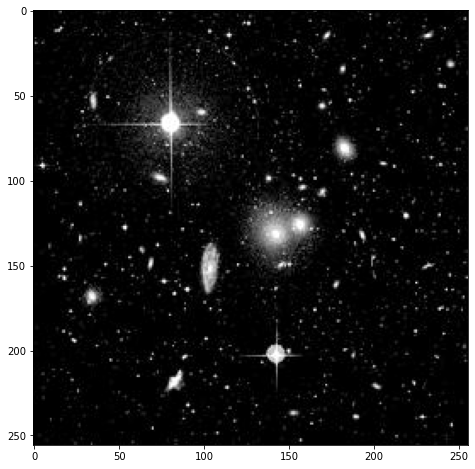

In [2]:
#image filepath
#file_path = "/content/hydra_poss.gif"
#file_path = "D:/B.TECH/CLASSES/3rd Year/SEM 6/IVP/Project/2/hydra_poss.gif"

I_clean = Image.open("Image_256.jpg").convert('L')

fig = plt.subplots(1,1,figsize=(8,8))
plt.imshow(I_clean,cmap="gray")

plt.show()

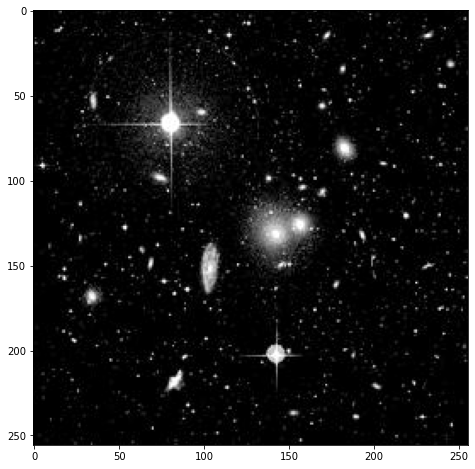

In [3]:
I_trail = Image.open("Image_256_trail.png").convert('L')

fig = plt.subplots(1,1,figsize=(8,8))
plt.imshow(I_clean,cmap="gray")

plt.show()

In [6]:
def image_degradation(I,blur=2,var=0.5):
    I = np.array(I)
    noise = np.random.normal(loc=0, scale=var, size=I.shape)    
    noisy_img = (np.array(I) + noise)

    img = Image.fromarray(np.uint8(noisy_img))
    #img = img.filter(ImageFilter.BoxBlur(blur))
    
    kernel = [[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]]
    img = convolve2d(img, kernel, mode='same')
    return img, kernel

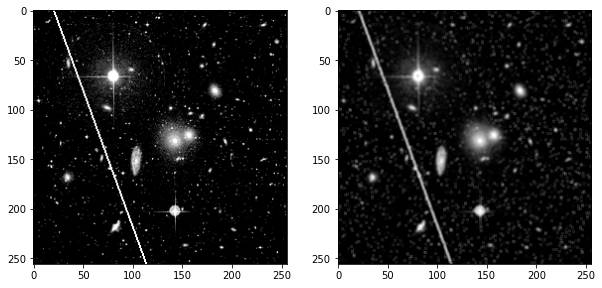

In [7]:
I_deg, b = image_degradation(I_trail,2,0.5)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(I_trail,cmap="gray")
ax[1].imshow(I_deg,cmap="gray")

plt.show()

In [20]:
def downsampling(I,size=64):
    x = np.array(I)
    D = np.zeros((size, x.shape[0]))
    
    scale = x.shape[0]/size
    
    for i in range(size):
        D[i, i*4] = 1
        
    y = np.dot(np.dot(D,x),D.T)
    y = y.reshape((64, 64))
    
    return y

In [21]:
def pixel_reduction(I, size):
    img = Image.fromarray(np.uint8(I))
    img = img.resize((size, size), resample=Image.LANCZOS)
    return img

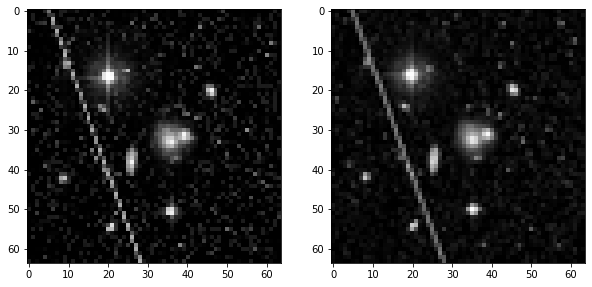

In [22]:
I_64 = pixel_reduction(I=I_deg, size=64)
y = downsampling(I=I_deg, size=64)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(y,cmap="gray")
ax[1].imshow(I_64,cmap="gray")

plt.show()

In [23]:
#z = I_64.save("Image_64.jpg")

In [24]:
def rotation_and_shift(I):
    shift_amount = np.random.uniform(-0.5, 0.5,2)
    I_shifted = shift(I, shift_amount)

    angle = np.random.uniform(-2, 2)
    I_rotated = rotate(I_shifted, angle, reshape=False)
  
    return I_rotated, shift_amount, angle

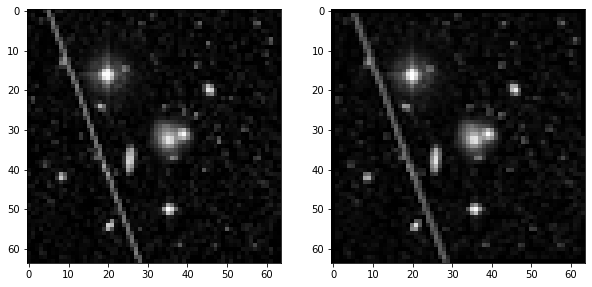

In [25]:
##generating 16 low-resolution images from the above low resolution image by rotating and shifting by a subpixel amouny
I_lr = []
I_shift_amount = []
I_rot_amount = []

for i in range(16):
    I_rot, shift_amount, rot_amount = rotation_and_shift(I_64)
    tmp = np.array(I_rot)
    I_lr.append(tmp)
    I_shift_amount.append(shift_amount)
    I_rot_amount.append(rot_amount)
    
I_lr = np.array(I_lr)
I_shift_amount = np.array(I_shift_amount)
I_rot_amount = np.array(I_rot_amount)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(I_64,cmap="gray")
ax[1].imshow(I_lr[0],cmap="gray")

plt.show()

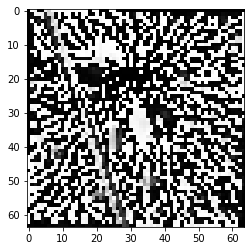

In [26]:
plt.imshow(I_lr[0] - I_lr[1], cmap = "gray")

## shifts and rotation estimation

In [27]:
x_shift = []
y_shift = []

for i in I_shift_amount:
    x_shift.append(i[0])
    y_shift.append(i[1])

In [28]:
x_shift = []
y_shift = []

for i in I_shift_amount:
    x_shift.append(i[0])
    y_shift.append(i[1])

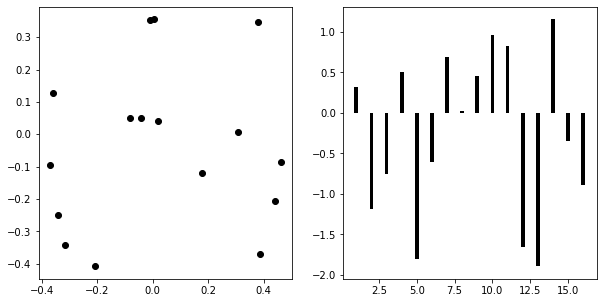

In [29]:
x = np.arange(1,17)
width = 0.25

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_shift, y_shift, color = "k")
ax[1].bar(x,I_rot_amount,width,color = "k")

plt.show()

In [30]:
##Registration of the Observation##


## Wavelet

In [31]:
def wavelet_sr(images, scale_factor=4, wavelet='haar', max_iter=10):
    
    """
    ---Wavelet filters---
    "dec_filter" is the decomposition or analysis filter used in wavelet transform. It is a low-pass filter and is applied 
    to the signal being analyzed in order to decompose it into different frequency subbands. The subbands are formed by 
    filtering the signal with a bank of high-pass and low-pass filters at different scales. The decimation or down-sampling
    operation is applied to each subband signal, resulting in a sequence of coefficients at a different resolution level.
    The coefficients at each level correspond to the wavelet transform of the signal at a particular scale.
    
    "rec_filter" is a high-pass reconstruction filter used in the inverse discrete wavelet transform (IDWT) to reconstruct 
    the high-frequency (detail) components of the image from its wavelet coefficients. The filter is used to convolve the 
    wavelet coefficients in the frequency domain and obtain the corresponding high-frequency signals in the spatial domain.
    """
    
    dec_filter, rec_filter = pywt.Wavelet(wavelet).filter_bank[:2]
    
    #wavelet decomposition of high-res image
    high_res_coeffs = pywt.dwt2(images[0], wavelet)
    high_res_coeffs_list = [(high_res_coeffs[0], high_res_coeffs[1])]
    
    #wavelet decomposition of low-res images
    low_res_coeffs_list = []
    for i in range(len(images)):
        coeffs = pywt.dwt2(images[i], wavelet)
        low_res_coeffs_list.append((coeffs[0], coeffs[1]))
    
    estimate_coeffs = high_res_coeffs  #initial estimate
    
    for i in range(max_iter):
        detail_sum = np.zeros_like(high_res_coeffs[1])    #intermediate estimate
        
        for j in range(len(images)):
            high_coeffs = low_res_coeffs_list[j]
            interp_func = interp2d(np.arange(high_coeffs[0].shape[1]), np.arange(high_coeffs[0].shape[0]), high_coeffs[0])
            interp_coeffs = interp_func(np.arange(0, high_coeffs[0].shape[1]-1, 1/scale_factor), np.arange(0, high_coeffs[0].shape[0]-1, 1/scale_factor))
            detail_sum += pywt.idwt2(((None, interp_coeffs, None), rec_filter, rec_filter),wavelet)
            #detail_sum += pywt.idwt2((interp_coeffs,(interp_coeffs, rec_filter, rec_filter)),wavelet)
            
        detail_sum /= len(images)
        estimate_coeffs = (high_res_coeffs[0], detail_sum)
        
        #New wavelet coefficients using EM algorithm
        for j in range(len(images)):
            
            low_coeffs = low_res_coeffs_list[j]
            interp_func = interp2d(np.arange(low_coeffs[0].shape[1]), np.arange(low_coeffs[0].shape[0]), low_coeffs[0])
            interp_coeffs = interp_func(np.arange(0, low_coeffs[0].shape[1]-1, 1/scale_factor), np.arange(0, low_coeffs[0].shape[0]-1, 1/scale_factor))
            new_coeffs = pywt.idwt2((None, interp_coeffs, low_coeffs[1]), rec_filter, rec_filter)
            detail_coeffs = pywt.dwt2(images[j], wavelet)[1]
            detail_coeffs -= pywt.dwt2(new_coeffs, wavelet)[1]
            variance = np.var(detail_coeffs)
            new_coeffs += pywt.idwt2((None, detail_coeffs/np.sqrt(variance)), dec_filter, dec_filter)*np.sqrt(variance)
            low_res_coeffs_list[j] = (new_coeffs, low_coeffs[1])
    
    # Compute final estimate
    final_estimate = pywt.idwt2(estimate_coeffs, rec_filter, rec_filter)
    final_estimate = np.clip(final_estimate, 0, 255).astype(np.uint8)
    
    return final_estimate

In [32]:
test = wavelet_sr(I_lr,4)

ValueError: `coeffs` must all be of equal size (or None)